# Notebook Astromark AI

Questo notebook carica i dati dei ticket, li unisce e li preprocessa (utilizzando spaCy per tokenizzazione, lemmatizzazione e NER), costruisce la pipeline di ML, esegue la grid search, salva/carica il modello e infine fornisce un esempio di utilizzo del ticket service.

In [1]:
import sys
import os
import pandas as pd
from service.pipeline import (
    merge_dataframes, 
    dataframe_o3, 
    dataframe_gc, 
    PROCESSED_DATA_PATH, 
    parallel_process_texts, 
    ClassifierType, 
    get_model,
    logger
)

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PROJECT_ROOT)

[INFO] Loading ticket-o3 from: H:\Informatica\astromark-ai\service\..\data\raw\ticket-o3.csv
[INFO] Loaded ticket-o3.csv with shape (4888, 3)
[INFO] Loading ticket-gemini from: H:\Informatica\astromark-ai\service\..\data\raw\ticket-gemini-claude.csv
[INFO] Loaded ticket-gemini-claude.csv with shape (1079, 3)
[INFO] Merging dataframes...
[INFO] Eliminated 433 duplicate rows
[INFO] Final merged dataset shape: (5534, 2)
[INFO] Loading spaCy model (it_core_news_sm)...
[INFO] Preprocessed data not found, starting parallel preprocessing...
[INFO] Parallel text processing with threading backend...
[INFO] Saving preprocessed data to: H:\Informatica\astromark-ai\service\..\data\processed\X_processed.csv
[INFO] Preprocessing complete and cached.


### Unione dei dati e preparazione delle variabili  
Questa cella unisce due DataFrame (`dataframe_o3` e `dataframe_gc`) utilizzando la funzione `merge_dataframes`, creando un dataset consolidato.

In [2]:
# Unione dei dati
merged_df = merge_dataframes(dataframe_o3, dataframe_gc)
X = merged_df['titolo_messaggio']
y = merged_df['categoria']
logger.info("Final merged dataset shape: %s", merged_df.shape)

[INFO] Merging dataframes...
[INFO] Eliminated 433 duplicate rows
[INFO] Final merged dataset shape: (5534, 2)


### Visualizzazione della Distribuzione delle Categorie  

Questa cella genera diversi grafici per analizzare la distribuzione delle categorie nel dataset `merged_df`, tra cui un grafico a barre, un grafico a torta, un grafico a barre con percentuali e un box plot della lunghezza del testo.  



Statistiche descrittive per categoria:
categoria
Segreteria    1235
Didattica     1123
Tecnico       1113
Accesso       1040
Profilo       1023
dtype: int64

Percentuali per categoria:
categoria
Segreteria    22.32
Didattica     20.29
Tecnico       20.11
Accesso       18.79
Profilo       18.49
Name: proportion, dtype: float64


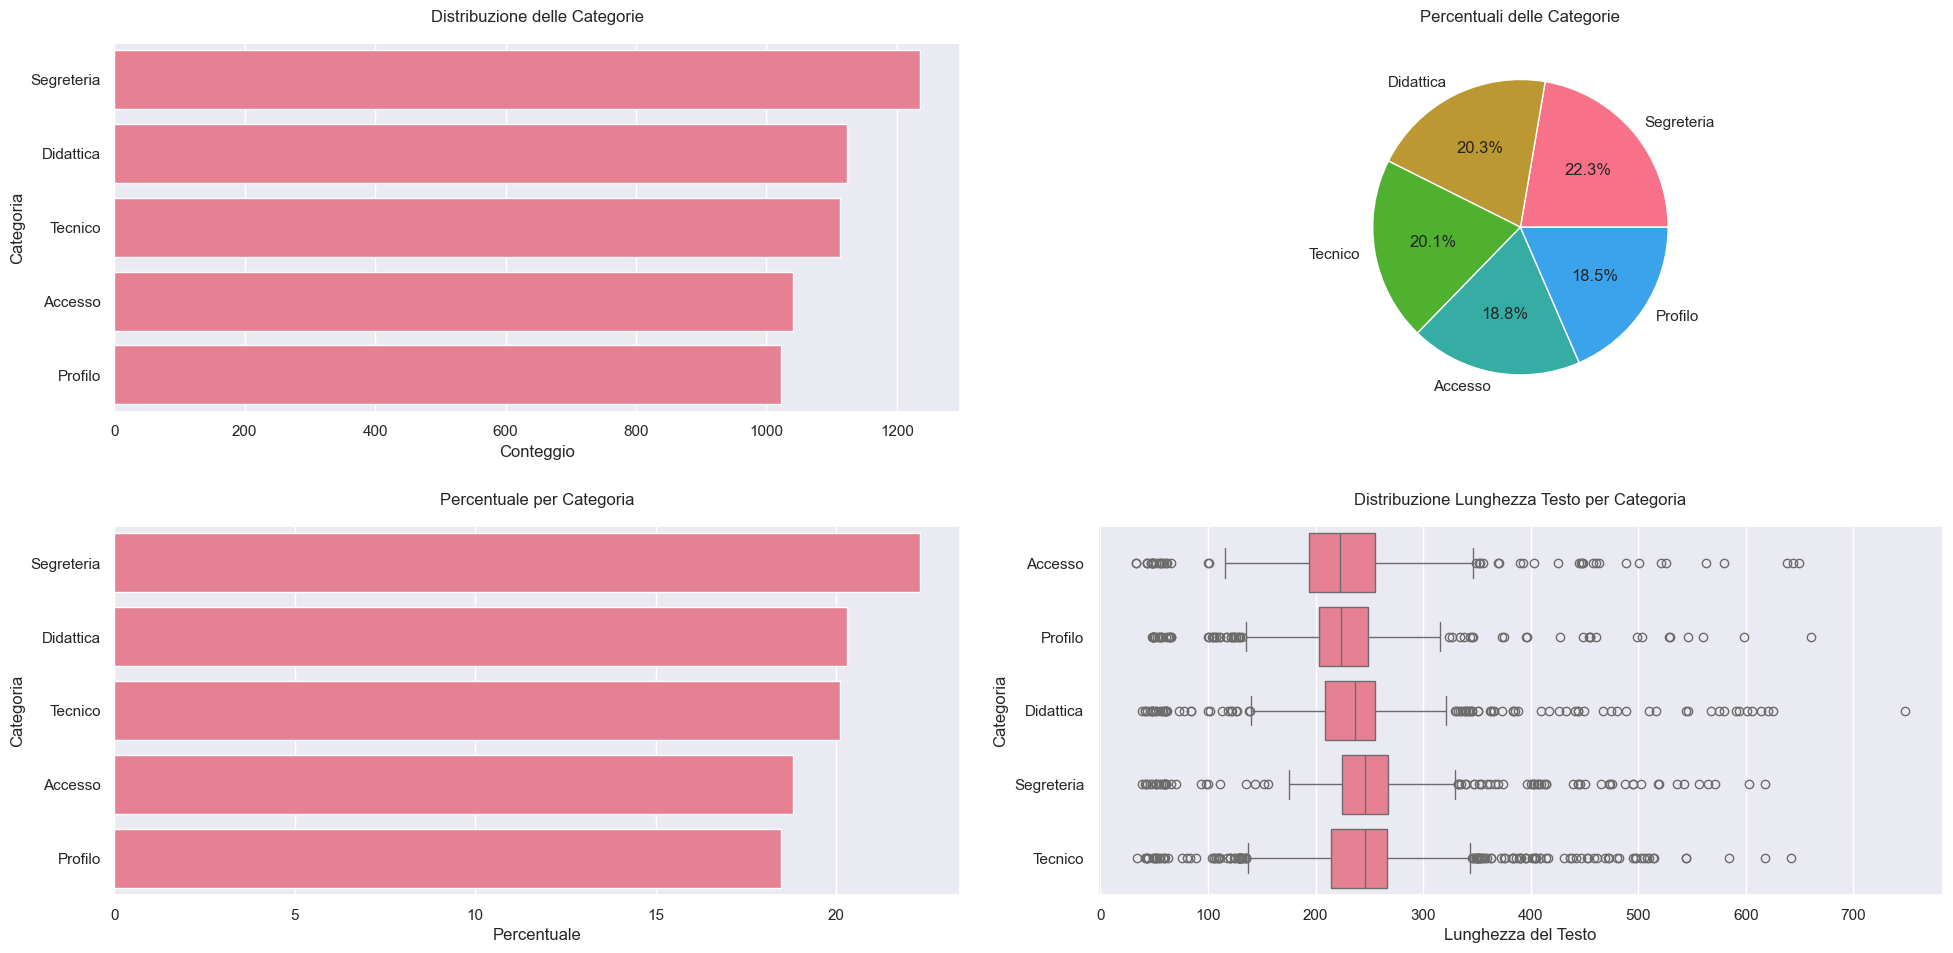

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Impostazioni per una migliore visualizzazione
plt.style.use('default')  # Utilizziamo lo stile default di matplotlib
sns.set_theme()  # Applica il tema base di seaborn
sns.set_palette("husl")

# Creazione di una figura con più sottografici
fig = plt.figure(figsize=(20, 10))

# 1. Grafico a barre della distribuzione delle categorie
plt.subplot(2, 2, 1)
sns.countplot(data=merged_df, y='categoria', order=merged_df['categoria'].value_counts().index)
plt.title('Distribuzione delle Categorie', pad=15)
plt.xlabel('Conteggio')
plt.ylabel('Categoria')

# 2. Grafico a torta delle percentuali
plt.subplot(2, 2, 2)
category_counts = merged_df['categoria'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Percentuali delle Categorie', pad=15)

# 3. Grafico a barre orizzontale con percentuali
plt.subplot(2, 2, 3)
category_percentages = (merged_df['categoria'].value_counts(normalize=True) * 100)
sns.barplot(x=category_percentages.values, y=category_percentages.index)
plt.title('Percentuale per Categoria', pad=15)
plt.xlabel('Percentuale')
plt.ylabel('Categoria')

# 4. Box plot della lunghezza del testo per categoria
plt.subplot(2, 2, 4)
merged_df['text_length'] = merged_df['titolo_messaggio'].str.len()
sns.boxplot(data=merged_df, x='text_length', y='categoria')
plt.title('Distribuzione Lunghezza Testo per Categoria', pad=15)
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Categoria')

# Aggiusta il layout
plt.tight_layout(pad=2.0)

# Mostra statistiche descrittive
print("\nStatistiche descrittive per categoria:")
print(merged_df.groupby('categoria').size().sort_values(ascending=False))
print("\nPercentuali per categoria:")
print(category_percentages.round(2))

# Mostra il plot
plt.show()

### Caricamento o Preprocessing dei Dati  

Questa cella verifica se i dati preprocessati sono già disponibili e, in caso contrario, li elabora e li salva.  


In [4]:
# Carica o processa i dati preprocessati
if os.path.exists(PROCESSED_DATA_PATH):
    logger.info("Loading preprocessed data from '%s'...", PROCESSED_DATA_PATH)
    df = pd.read_csv(PROCESSED_DATA_PATH)
    X_processed = df["processed_text"]
else:
    logger.info("Preprocessed data not found, starting parallel preprocessing...")
    X_processed = parallel_process_texts(X, n_jobs=-1)
    logger.info("Saving preprocessed data to: %s", PROCESSED_DATA_PATH)
    X_processed_df = pd.DataFrame(X_processed, columns=["processed_text"])
    X_processed_df.to_csv(PROCESSED_DATA_PATH, index=False)
    logger.info("Preprocessing complete and cached.")

[INFO] Loading preprocessed data from 'H:\Informatica\astromark-ai\service\..\data\processed\X_processed.csv'...


## Fine della Pipeline

I dati sono stati caricati, preprocessati e il modello (ottenuto tramite Grid Search) è stato caricato o addestrato e salvato nella cartella `../data/trained`
#### Monitoraggio delle Risorse (CPU e Memoria) Durante l'Addestramento di Naive Bayes

Questa cella misura l'**andamento dell'uso della CPU e della memoria RAM** durante l'addestramento del classificatore **Naive Bayes**.  


[INFO] Measuring CPU & RAM usage while training naive_bayes...
[INFO] CPU & RAM usage measurement complete.
[INFO] Training finished in 3.52 seconds.
[INFO] Best parameters for naive_bayes: {'clf__alpha': 1.0, 'tfidf__max_df': 0.85, 'tfidf__min_df': 3}


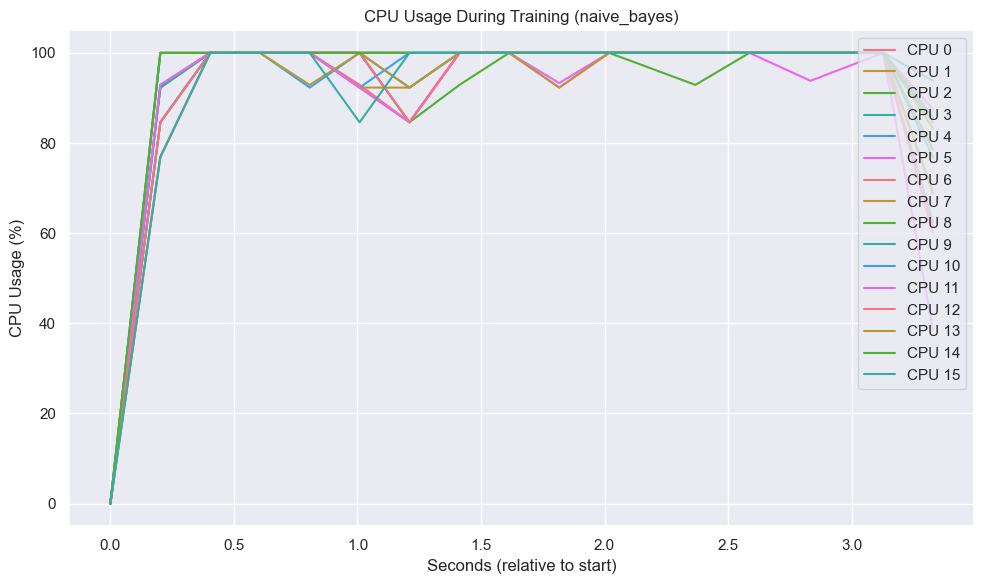

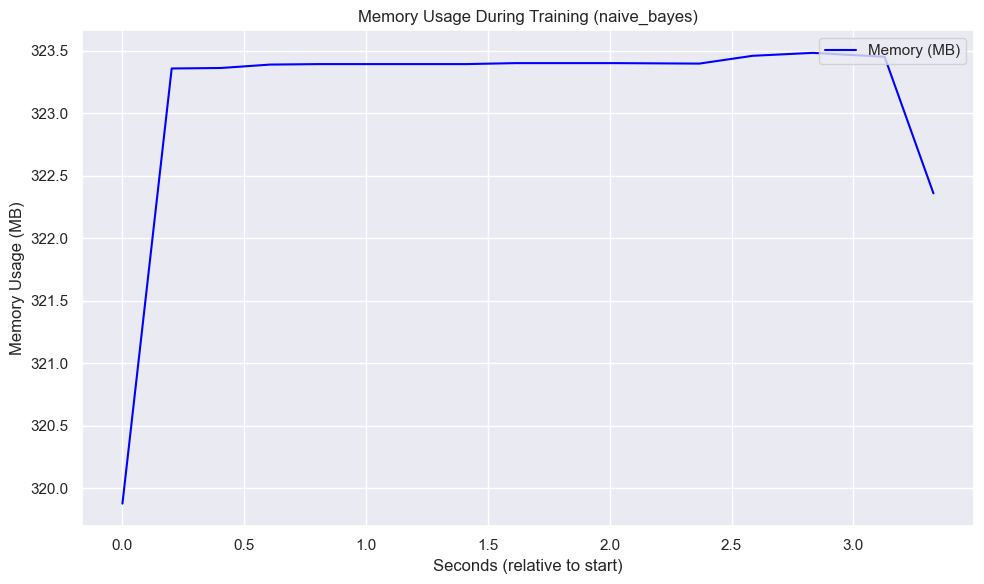

[INFO] Model saved to H:\Informatica\astromark-ai\service\..\data\trained\trained_model_nb.pkl.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=3000, min_df=3,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('clf', MultinomialNB())])

In [5]:
from service.report_predict import evaluate_model_with_kfold
from service.pipeline import measure_pc_metrics_during_training
measure_pc_metrics_during_training(ClassifierType.NAIVE_BAYES, save_plot=False)

### Valutazione del Modello Naive Bayes con K-Fold Cross-Validation  

Questa cella esegue una **validazione incrociata (K-Fold cross-validation)** per il classificatore **Naive Bayes**, utilizzando il dataset `X_processed` per le caratteristiche e `y` per le etichette.  


[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


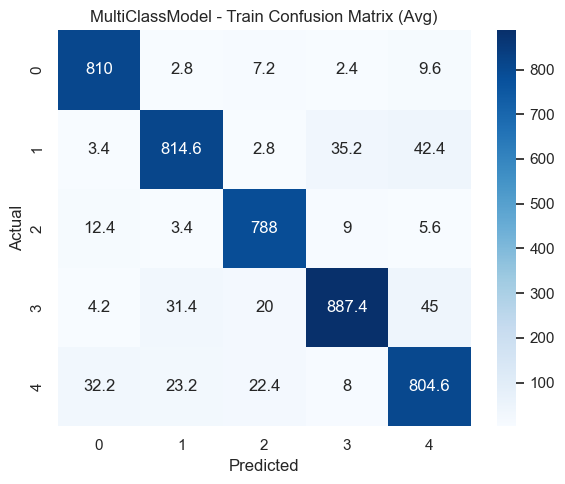

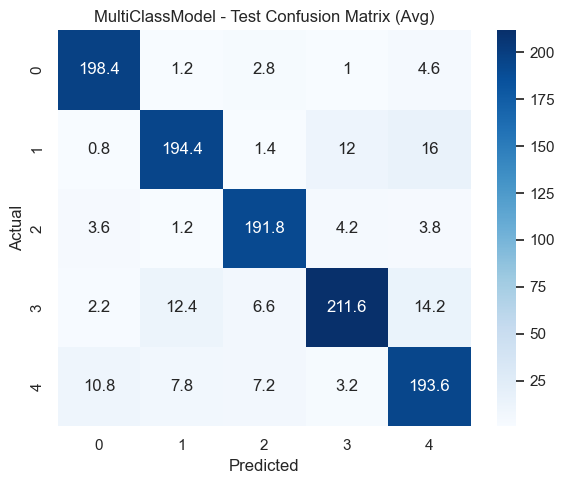

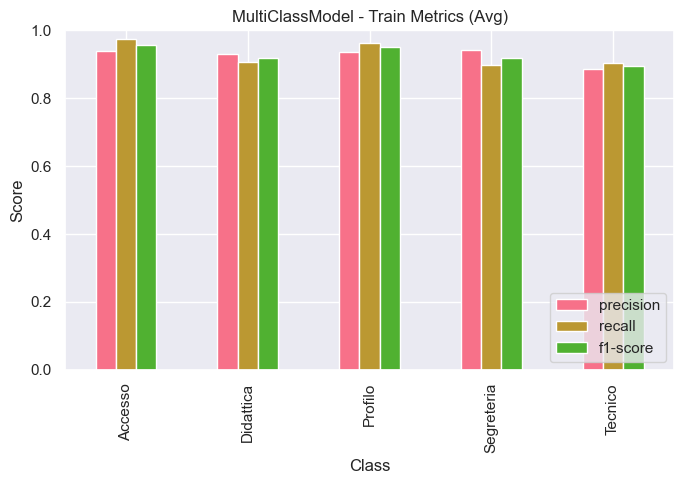

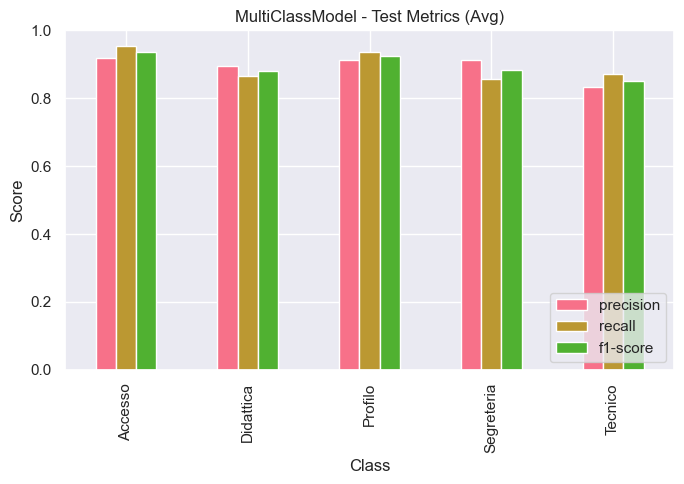

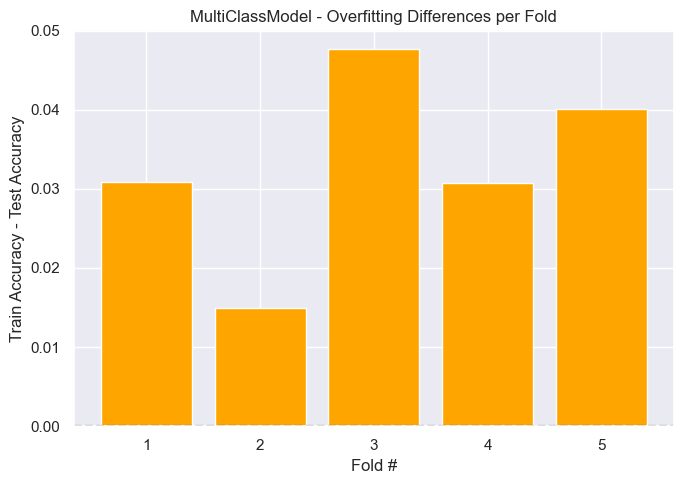

{'train': {'accuracy': 0.9271321134640456,
  'confusion_matrix': array([[810. ,   2.8,   7.2,   2.4,   9.6],
         [  3.4, 814.6,   2.8,  35.2,  42.4],
         [ 12.4,   3.4, 788. ,   9. ,   5.6],
         [  4.2,  31.4,  20. , 887.4,  45. ],
         [ 32.2,  23.2,  22.4,   8. , 804.6]]),
  'report_df':               precision    recall  f1-score      support
  Accesso        0.939462  0.973538  0.956194   832.000000
  Didattica      0.930549  0.906670  0.918441   898.400000
  Profilo        0.937754  0.962797  0.950092   818.400000
  Segreteria     0.942031  0.898187  0.919582   988.000000
  Tecnico        0.886956  0.903598  0.895190   890.400000
  accuracy       0.927132  0.927132  0.927132     0.927132
  macro avg      0.927350  0.928958  0.927900  4427.200000
  weighted avg   0.927339  0.927132  0.926975  4427.200000},
 'test': {'accuracy': 0.8942891773703753,
  'confusion_matrix': array([[198.4,   1.2,   2.8,   1. ,   4.6],
         [  0.8, 194.4,   1.4,  12. ,  16. ],
     

In [6]:
evaluate_model_with_kfold(get_model(ClassifierType.NAIVE_BAYES), X_processed, y)

### Monitoraggio delle Risorse (CPU e Memoria) Durante l'Addestramento di SVM

Questa cella misura l'**andamento dell'uso della CPU e della memoria RAM** durante l'addestramento del classificatore **SVM**.  


[INFO] Measuring CPU & RAM usage while training svm...
[INFO] CPU & RAM usage measurement complete.
[INFO] Training finished in 190.57 seconds.
[INFO] Best parameters for svm: {'clf__C': 2.0, 'svd__n_components': 150, 'tfidf__max_df': 0.85, 'tfidf__min_df': 1}


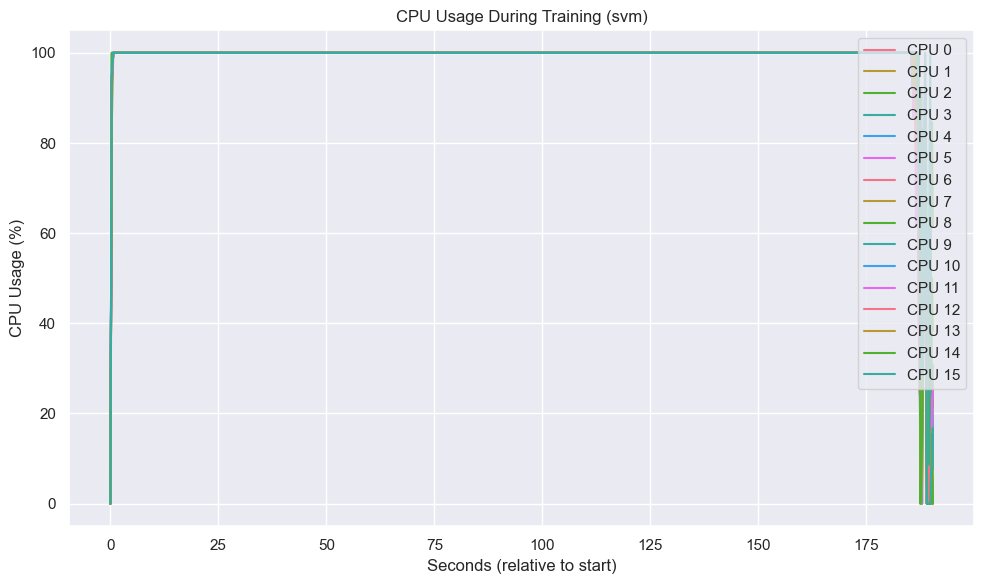

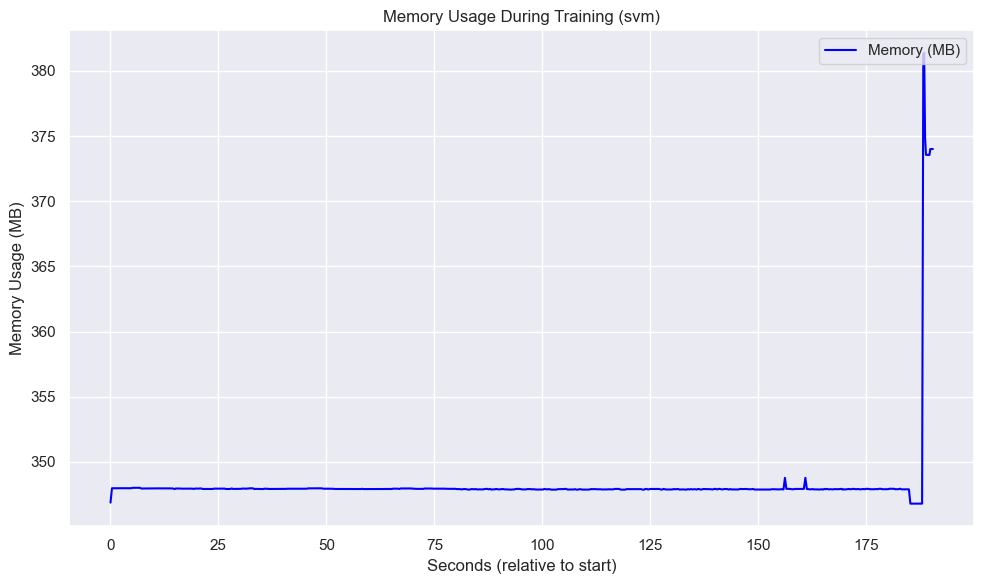

[INFO] Model saved to H:\Informatica\astromark-ai\service\..\data\trained\trained_model_svm.pkl.


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=3000,
                                 ngram_range=(1, 2), sublinear_tf=True)),
                ('svd', TruncatedSVD(n_components=150, random_state=42)),
                ('clf',
                 SVC(C=2.0, kernel='linear', probability=True,
                     random_state=42))])

In [7]:
measure_pc_metrics_during_training(ClassifierType.SVM, save_plot=False)

### Valutazione del Modello SVM con K-Fold Cross-Validation  

Questa cella esegue una **validazione incrociata (K-Fold cross-validation)** per il classificatore **SVM**, utilizzando il dataset `X_processed` per le caratteristiche e `y` per le etichette. 

[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


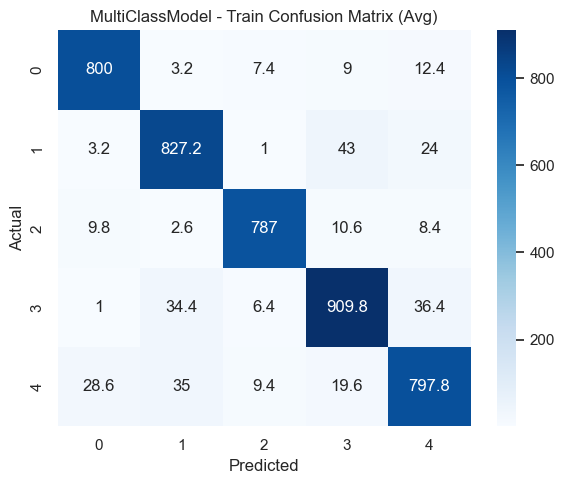

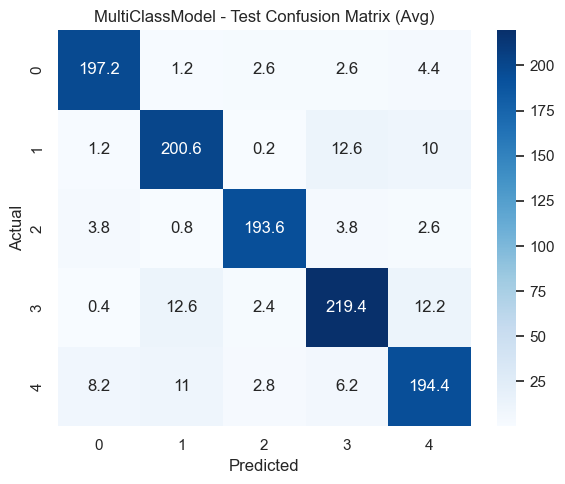

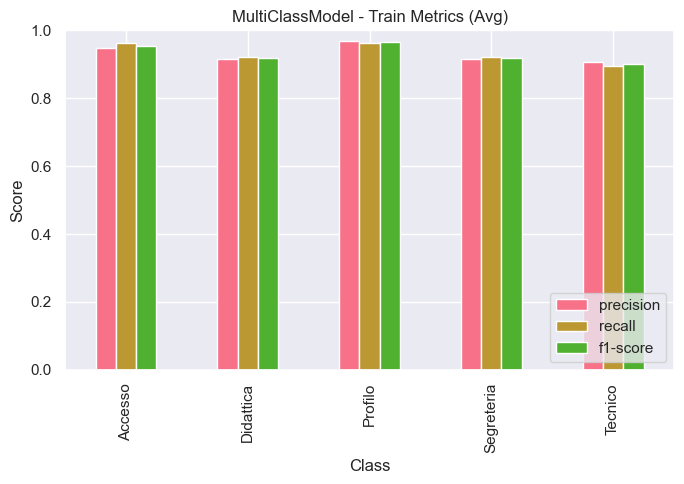

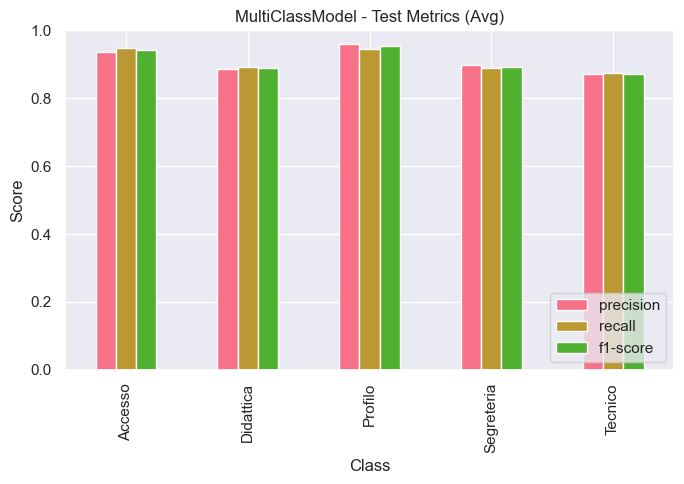

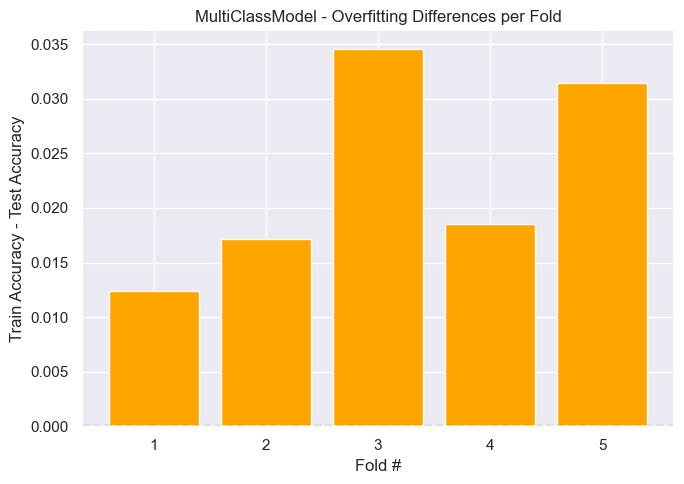

{'train': {'accuracy': 0.9310173834740381,
  'confusion_matrix': array([[800. ,   3.2,   7.4,   9. ,  12.4],
         [  3.2, 827.2,   1. ,  43. ,  24. ],
         [  9.8,   2.6, 787. ,  10.6,   8.4],
         [  1. ,  34.4,   6.4, 909.8,  36.4],
         [ 28.6,  35. ,   9.4,  19.6, 797.8]]),
  'report_df':               precision    recall  f1-score      support
  Accesso        0.949444  0.961565  0.955456   832.000000
  Didattica      0.916717  0.920732  0.918702   898.400000
  Profilo        0.970217  0.961591  0.965863   818.400000
  Segreteria     0.917114  0.920810  0.918946   988.000000
  Tecnico        0.907706  0.896059  0.901843   890.400000
  accuracy       0.931017  0.931017  0.931017     0.931017
  macro avg      0.932239  0.932151  0.932162  4427.200000
  weighted avg   0.931021  0.931017  0.930987  4427.200000},
 'test': {'accuracy': 0.9082021199958836,
  'confusion_matrix': array([[1.972e+02, 1.200e+00, 2.600e+00, 2.600e+00, 4.400e+00],
         [1.200e+00, 2.006e+02,

In [8]:
evaluate_model_with_kfold(get_model(ClassifierType.SVM), X_processed, y)

### Confronto tra Classificatori Naive Bayes e SVM con K-Fold Cross-Validation  

Questa cella esegue un **confronto tra due classificatori** (Naive Bayes e SVM) utilizzando la **validazione incrociata K-Fold** su tutto il dataset preprocessato. I risultati vengono calcolati per ogni fold e vengono comparati per determinare quale classificatore offre le migliori prestazioni.  


[INFO] Starting K-Fold comparison of Naive Bayes vs. SVM...
[INFO] Comparing Naive Bayes vs. SVM with 5-fold cross-validation...
[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] Evaluating Naive Bayes with KFold...
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


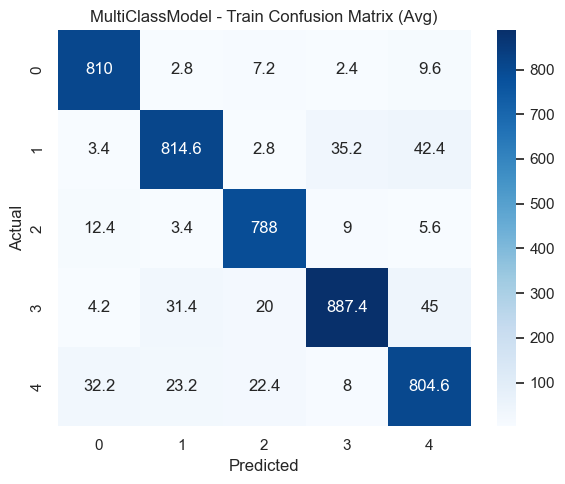

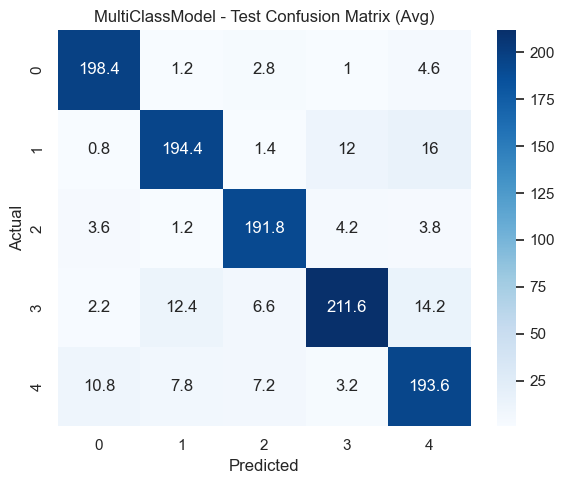

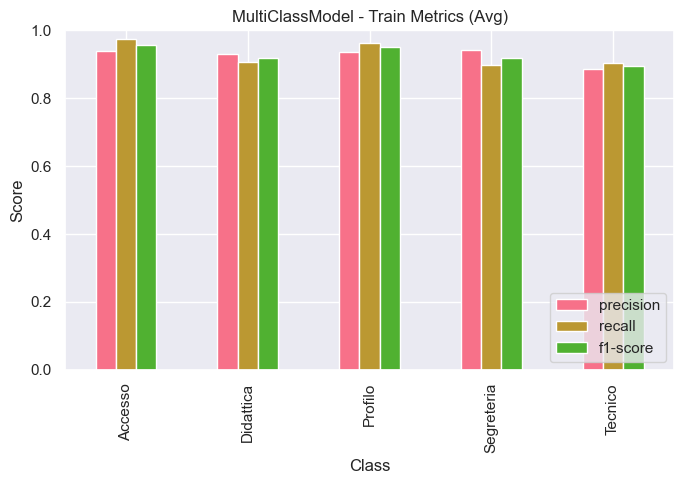

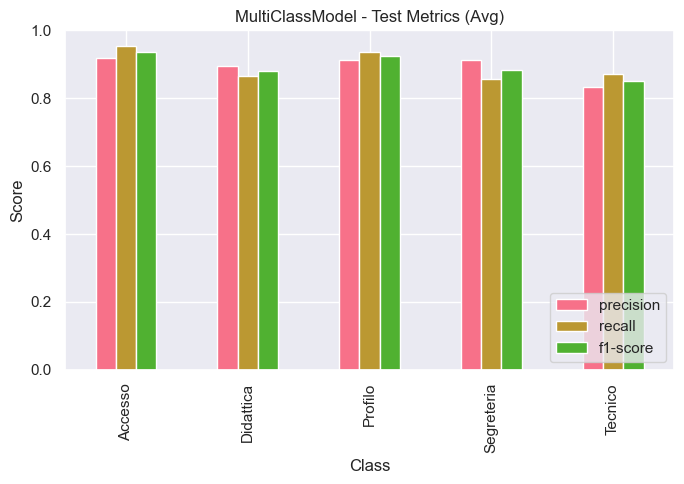

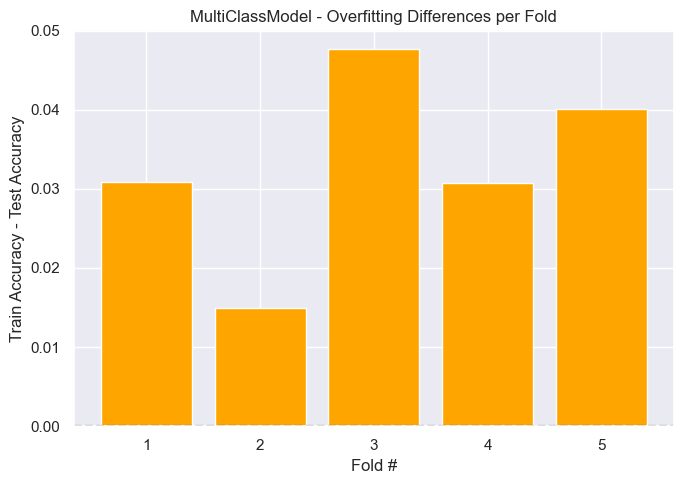

[INFO] Evaluating SVM with KFold...
[INFO] === Fold 1/5 ===
[INFO] === Fold 2/5 ===
[INFO] === Fold 3/5 ===
[INFO] === Fold 4/5 ===
[INFO] === Fold 5/5 ===


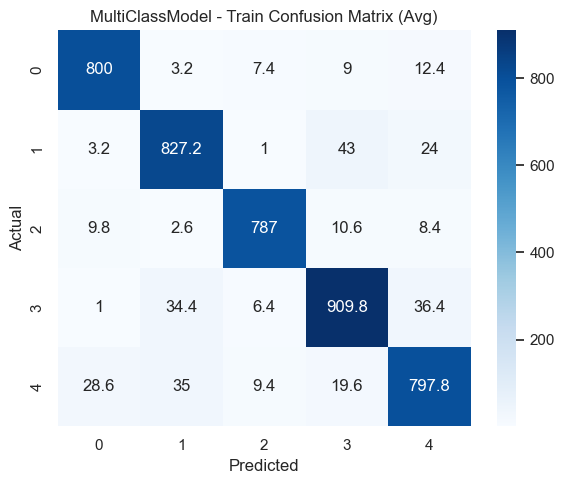

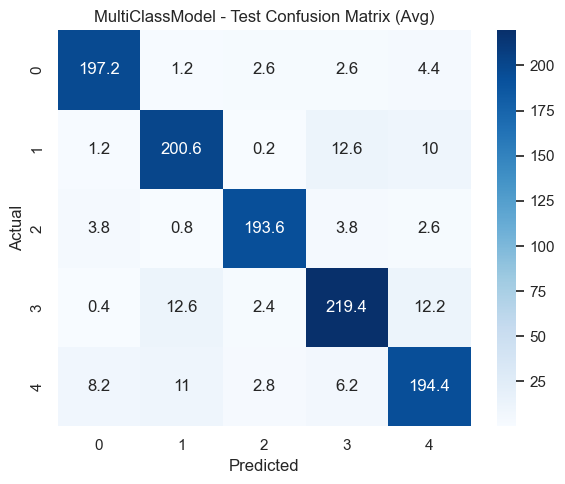

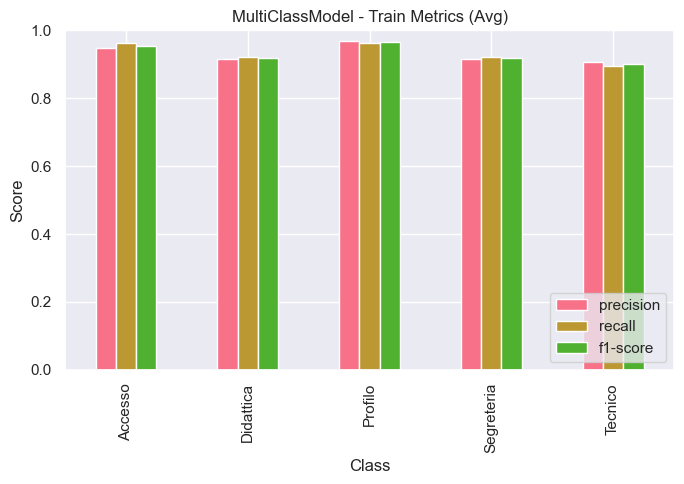

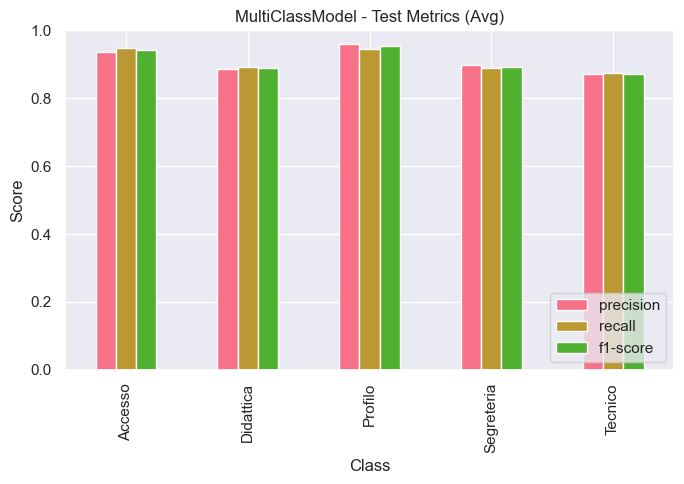

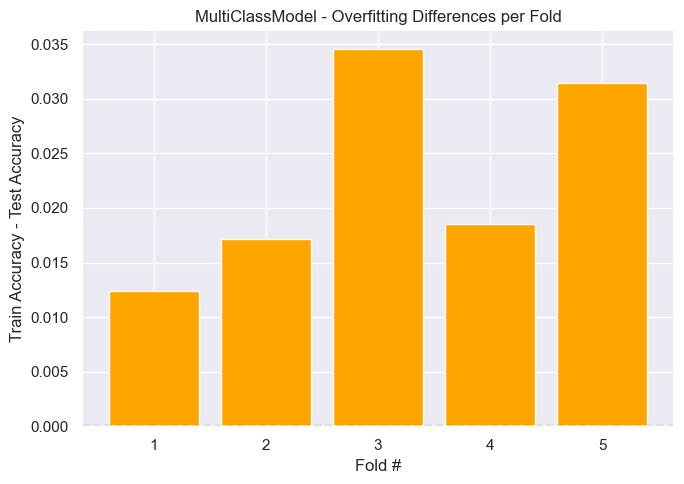

[INFO] KFold Comparison:
 Classifier  Train Accuracy  Test Accuracy  Overfitting (Train-Test)
Naive_Bayes        0.927132       0.894289                  0.032843
        SVM        0.931017       0.908202                  0.022815


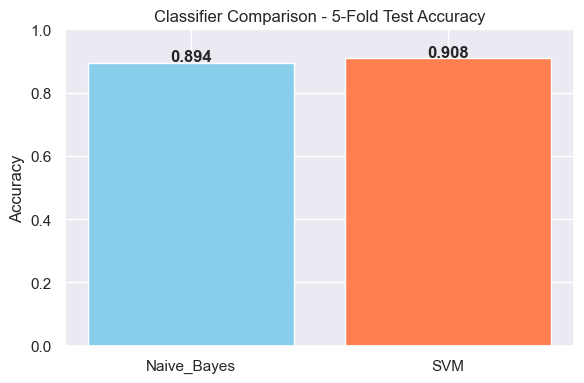

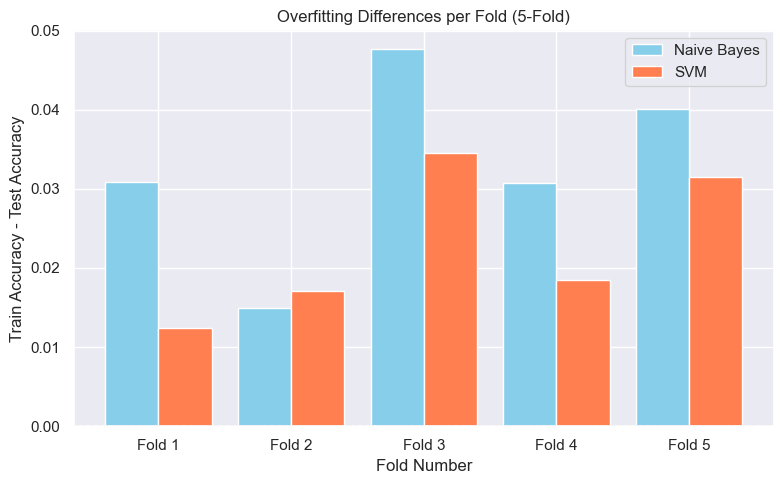

Comparison Results (Naive Bayes vs. SVM):


' Classifier  Train Accuracy  Test Accuracy  Overfitting (Train-Test)\nNaive_Bayes        0.927132       0.894289                  0.032843\n        SVM        0.931017       0.908202                  0.022815'

In [9]:
from service.report_predict import compare_classifiers_with_kfold

# Example usage of compare_classifiers_with_kfold
logger.info("Starting K-Fold comparison of Naive Bayes vs. SVM...")

# Use the entire preprocessed dataset
X_small, y_small = X_processed, y

# Compare the two classifiers with 5-fold CV,
# saving both the plots and the resulting DataFrame.
df_results = compare_classifiers_with_kfold(
    X_small,
    y_small,
    n_splits=5,
    shuffle=True,
    random_state=42,
    save_plots=False,  # True -> saves bar charts
    save_data=False  # True -> saves the final df_compare to CSV
)

print("Comparison Results (Naive Bayes vs. SVM):")
df_results.to_string(index=False)

## Fase di Controllo e Valutazione Completata - Passiamo all'Utilizzo del Dataset
Esempio di Funzione del Ticket Service: classificazione del Messaggio

In [10]:
# Esempio: Funzione per il Ticket Service
def ticket_service(title, message, classifier_type):
    get_model(classifier_type)
    full_text = f"{title} {message}".strip()
    if not full_text:
        return ["Nessun input fornito"]
    # Importa la funzione predict_category dal modulo report_predict
    from service.report_predict import predict_category
    predictions = predict_category(full_text, classifier_type)
    print("Predizioni:", predictions)
    return predictions

### Esempio di utilizzo con SVM

In [11]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
pd.DataFrame(ticket_service(example_title, example_message, ClassifierType.SVM), columns=["Class", "Probability"])

[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.
[INFO] Predicting category for a new message...
[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_svm.pkl...
[INFO] Using saved model for svm.


Predizioni: [('Tecnico', 0.9855941917015415), ('Segreteria', 0.0060118270404172), ('Accesso', 0.00526701333514752)]


,Class,Probability
0,Tecnico,0.985594
1,Segreteria,0.006012
2,Accesso,0.005267


### Esempio di utilizzo con NAIVE BAYES

In [12]:
example_title = "Problema con la stampante"
example_message = "La stampante non funziona correttamente."
pd.DataFrame(ticket_service(example_title, example_message, ClassifierType.NAIVE_BAYES), columns=["Class", "Probability"])

[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.
[INFO] Predicting category for a new message...
[INFO] Loading saved model from H:\Informatica\astromark-ai\service\..\data\trained\trained_model_nb.pkl...
[INFO] Using saved model for naive_bayes.


Predizioni: [('Tecnico', 0.8121920668491109), ('Accesso', 0.07725799712998233), ('Didattica', 0.039986874434789)]


,Class,Probability
0,Tecnico,0.812192
1,Accesso,0.077258
2,Didattica,0.039987


## Analisi del Fenomeno di Hughes con TruncatedSVD

In questa sezione del notebook viene eseguita un'analisi per studiare l'effetto della variazione del numero di componenti del **TruncatedSVD** sulle performance del modello SVM. Utilizzando la funzione `plot_hughes_phenomenon_truncated_svd_fixed` importata dal modulo `service.report_predict`, il codice applica una validazione incrociata a 5 fold sul dataset ridotto (`X_small` e `y_small`).

In particolare, la funzione testa cinque specifici valori di componenti (100, 200, 500, 1000, 2000) e calcola l'accuratezza media sui dati di training e di test per ciascun valore. Questo grafico permette di osservare il fenomeno di Hughes, evidenziando come la scelta del numero di componenti possa influenzare la capacità del modello di generalizzare, aiutandoci a individuare un possibile punto ottimale in cui bilanciare la complessità del modello e le sue performance.


[INFO] Creating Hughes Phenomenon graph for fixed TruncatedSVD components: 100, 200, 500, 1000, 2000...


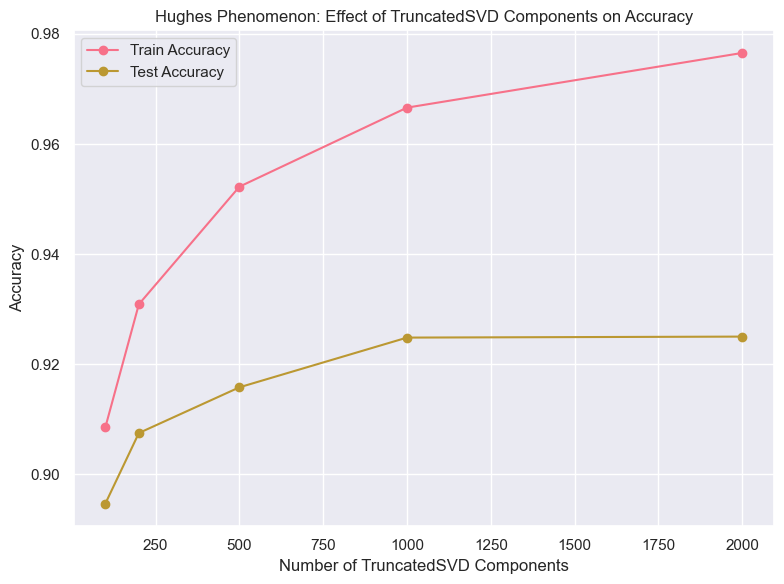

[INFO] Hughes Phenomenon graph created with components [100, 200, 500, 1000, 2000].


In [13]:
from service.report_predict import plot_hughes_phenomenon_truncated_svd_fixed
plot_hughes_phenomenon_truncated_svd_fixed(
    X_small,
    y_small,
    n_splits=5,
)

# Valutazione del Modello Word2Vec con Cross-Validation a 5 Fold

In questa sezione valutiamo un modello di classificazione testuale basato su Word2Vec, utilizzando una procedura di cross-validation a 5 fold con un classificatore SVM.

**Cosa fa il codice:**
- **Calcolo delle Metriche:** Vengono calcolate e stampate le metriche principali per ogni fold, quali:
  - Accuratezza (accuracy)
  - Matrice di Confusione
  - Classification Report (precision, recall, f1-score)
- **Aggregazione dei Risultati:** Al termine della validazione, le metriche dei vari fold vengono aggregate per fornire una panoramica complessiva delle performance del modello.

In [14]:
from service.word2vec_pipeline import evaluate_word2vec_model_kfold

evaluate_word2vec_model_kfold(ClassifierType.SVM, X, y)

[INFO] No saved Word2Vec model found for svm. Training a new one...


=== Fold 1 ===


[INFO] collecting all words and their counts
[INFO] PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
[INFO] collected 4552 word types from a corpus of 108199 raw words and 5534 sentences
[INFO] Creating a fresh vocabulary
[INFO] Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 4552 unique words (100.00% of original 4552, drops 0)', 'datetime': '2025-02-09T17:12:51.196659', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
[INFO] Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 108199 word corpus (100.00% of original 108199, drops 0)', 'datetime': '2025-02-09T17:12:51.197656', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'prepare_vocab'}
[INFO] deleting the raw counts dictionary of 4552 items
[INFO

Train Accuracy: 0.7018
Test Accuracy:  0.7109
Confusion Matrix:
 [[151   2  13   7  28]
 [  6 157   2  38  25]
 [ 10   5 199   5  13]
 [ 16  33   4 139  43]
 [ 17  24   3  26 141]]
Classification Report:
  Accesso: {'precision': 0.755, 'recall': 0.7512437810945274, 'f1-score': 0.7531172069825436, 'support': 201.0}
  Didattica: {'precision': 0.7104072398190046, 'recall': 0.6885964912280702, 'f1-score': 0.6993318485523385, 'support': 228.0}
  Profilo: {'precision': 0.9004524886877828, 'recall': 0.8577586206896551, 'f1-score': 0.8785871964679912, 'support': 232.0}
  Segreteria: {'precision': 0.6465116279069767, 'recall': 0.5914893617021276, 'f1-score': 0.6177777777777778, 'support': 235.0}
  Tecnico: {'precision': 0.564, 'recall': 0.6682464454976303, 'f1-score': 0.6117136659436009, 'support': 211.0}
  accuracy: 0.7109304426377597
  macro avg: {'precision': 0.7152742712827529, 'recall': 0.7114669400424021, 'f1-score': 0.7121055391448504, 'support': 1107.0}
  weighted avg: {'precision': 0.7

[INFO] EPOCH 0: training on 150253 raw words (119029 effective words) took 0.0s, 3144216 effective words/s
[INFO] EPOCH 1: training on 150253 raw words (119142 effective words) took 0.0s, 2760856 effective words/s
[INFO] EPOCH 2: training on 150253 raw words (119158 effective words) took 0.0s, 2869777 effective words/s
[INFO] EPOCH 3: training on 150253 raw words (119087 effective words) took 0.0s, 2906035 effective words/s
[INFO] EPOCH 4: training on 150253 raw words (119077 effective words) took 0.0s, 3081767 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 751265 raw words (595493 effective words) took 0.2s, 2497917 effective words/s', 'datetime': '2025-02-09T17:12:55.723456', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11364, vector_size=50, alpha=0.025>', 'datetime': '2025-02

Train Accuracy: 0.7025
Test Accuracy:  0.7100
Confusion Matrix:
 [[167   0   9   8  28]
 [  8 145   0  28  46]
 [ 11   9 161   1   7]
 [  9  36   5 159  37]
 [ 28  18  12  21 154]]
Classification Report:
  Accesso: {'precision': 0.7488789237668162, 'recall': 0.7877358490566038, 'f1-score': 0.767816091954023, 'support': 212.0}
  Didattica: {'precision': 0.6971153846153846, 'recall': 0.6387665198237885, 'f1-score': 0.6666666666666666, 'support': 227.0}
  Profilo: {'precision': 0.8609625668449198, 'recall': 0.8518518518518519, 'f1-score': 0.8563829787234043, 'support': 189.0}
  Segreteria: {'precision': 0.7327188940092166, 'recall': 0.6463414634146342, 'f1-score': 0.6868250539956804, 'support': 246.0}
  Tecnico: {'precision': 0.5661764705882353, 'recall': 0.6609442060085837, 'f1-score': 0.6099009900990099, 'support': 233.0}
  accuracy: 0.7100271002710027
  macro avg: {'precision': 0.7211704479649145, 'recall': 0.7171279780310924, 'f1-score': 0.7175183562877568, 'support': 1107.0}
  weight

[INFO] EPOCH 0: training on 150361 raw words (119166 effective words) took 0.0s, 3164705 effective words/s
[INFO] EPOCH 1: training on 150361 raw words (119263 effective words) took 0.0s, 2746217 effective words/s
[INFO] EPOCH 2: training on 150361 raw words (119286 effective words) took 0.0s, 3097324 effective words/s
[INFO] EPOCH 3: training on 150361 raw words (119119 effective words) took 0.0s, 2955550 effective words/s
[INFO] EPOCH 4: training on 150361 raw words (119152 effective words) took 0.0s, 2970860 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 751805 raw words (595986 effective words) took 0.2s, 2510793 effective words/s', 'datetime': '2025-02-09T17:12:58.362070', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11306, vector_size=50, alpha=0.025>', 'datetime': '2025-02

Train Accuracy: 0.7167
Test Accuracy:  0.6838
Confusion Matrix:
 [[152   2   7  13  33]
 [ 13 136   3  28  45]
 [ 16   6 164   5  12]
 [ 10  32   6 154  33]
 [ 34  18   8  26 151]]
Classification Report:
  Accesso: {'precision': 0.6755555555555556, 'recall': 0.7342995169082126, 'f1-score': 0.7037037037037037, 'support': 207.0}
  Didattica: {'precision': 0.7010309278350515, 'recall': 0.6044444444444445, 'f1-score': 0.649164677804296, 'support': 225.0}
  Profilo: {'precision': 0.8723404255319149, 'recall': 0.8078817733990148, 'f1-score': 0.8388746803069054, 'support': 203.0}
  Segreteria: {'precision': 0.6814159292035398, 'recall': 0.6553191489361702, 'f1-score': 0.6681127982646421, 'support': 235.0}
  Tecnico: {'precision': 0.551094890510949, 'recall': 0.6371308016877637, 'f1-score': 0.5909980430528375, 'support': 237.0}
  accuracy: 0.6838301716350497
  macro avg: {'precision': 0.6962875457274021, 'recall': 0.6878151370751211, 'f1-score': 0.690170780626477, 'support': 1107.0}
  weighted

[INFO] EPOCH 0: training on 150251 raw words (119022 effective words) took 0.0s, 2996247 effective words/s
[INFO] EPOCH 1: training on 150251 raw words (119075 effective words) took 0.0s, 2632097 effective words/s
[INFO] EPOCH 2: training on 150251 raw words (118933 effective words) took 0.0s, 3014450 effective words/s
[INFO] EPOCH 3: training on 150251 raw words (119038 effective words) took 0.0s, 3130034 effective words/s
[INFO] EPOCH 4: training on 150251 raw words (119055 effective words) took 0.0s, 2987181 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 751255 raw words (595123 effective words) took 0.2s, 2496374 effective words/s', 'datetime': '2025-02-09T17:13:00.853054', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11403, vector_size=50, alpha=0.025>', 'datetime': '2025-02

Train Accuracy: 0.7054
Test Accuracy:  0.6956
Confusion Matrix:
 [[160   4  17   9  26]
 [ 10 145   4  41  34]
 [ 19   6 162   6  10]
 [  4  28   3 183  31]
 [ 43  16   6  20 120]]
Classification Report:
  Accesso: {'precision': 0.6779661016949152, 'recall': 0.7407407407407407, 'f1-score': 0.7079646017699115, 'support': 216.0}
  Didattica: {'precision': 0.7286432160804021, 'recall': 0.6196581196581197, 'f1-score': 0.6697459584295612, 'support': 234.0}
  Profilo: {'precision': 0.84375, 'recall': 0.7980295566502463, 'f1-score': 0.8202531645569621, 'support': 203.0}
  Segreteria: {'precision': 0.7065637065637066, 'recall': 0.7349397590361446, 'f1-score': 0.7204724409448819, 'support': 249.0}
  Tecnico: {'precision': 0.5429864253393665, 'recall': 0.5853658536585366, 'f1-score': 0.5633802816901409, 'support': 205.0}
  accuracy: 0.6955736224028907
  macro avg: {'precision': 0.699981889935678, 'recall': 0.6957468059487575, 'f1-score': 0.6963632894782915, 'support': 1107.0}
  weighted avg: {'p

[INFO] EPOCH 0: training on 150938 raw words (119779 effective words) took 0.0s, 2825729 effective words/s
[INFO] EPOCH 1: training on 150938 raw words (119596 effective words) took 0.0s, 2697413 effective words/s
[INFO] EPOCH 2: training on 150938 raw words (119906 effective words) took 0.0s, 3092481 effective words/s
[INFO] EPOCH 3: training on 150938 raw words (119685 effective words) took 0.0s, 3135118 effective words/s
[INFO] EPOCH 4: training on 150938 raw words (119674 effective words) took 0.0s, 2964936 effective words/s
[INFO] Word2Vec lifecycle event {'msg': 'training on 754690 raw words (598640 effective words) took 0.2s, 2480867 effective words/s', 'datetime': '2025-02-09T17:13:03.375838', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'train'}
[INFO] Word2Vec lifecycle event {'params': 'Word2Vec<vocab=11357, vector_size=50, alpha=0.025>', 'datetime': '2025-02

Train Accuracy: 0.7112
Test Accuracy:  0.6935
Confusion Matrix:
 [[156   1  14   4  29]
 [  3 136   2  24  44]
 [ 10   8 163   5  10]
 [ 10  39   5 175  41]
 [ 28  27   6  29 137]]
Classification Report:
  Accesso: {'precision': 0.7536231884057971, 'recall': 0.7647058823529411, 'f1-score': 0.7591240875912408, 'support': 204.0}
  Didattica: {'precision': 0.6445497630331753, 'recall': 0.6507177033492823, 'f1-score': 0.6476190476190476, 'support': 209.0}
  Profilo: {'precision': 0.8578947368421053, 'recall': 0.8316326530612245, 'f1-score': 0.844559585492228, 'support': 196.0}
  Segreteria: {'precision': 0.7383966244725738, 'recall': 0.6481481481481481, 'f1-score': 0.6903353057199211, 'support': 270.0}
  Tecnico: {'precision': 0.524904214559387, 'recall': 0.6035242290748899, 'f1-score': 0.5614754098360656, 'support': 227.0}
  accuracy: 0.6934900542495479
  macro avg: {'precision': 0.7038737054626077, 'recall': 0.6997457231972971, 'f1-score': 0.7006226872517006, 'support': 1106.0}
  weighte

{'train': {'accuracy': 0.7075350731295129,
  'confusion_matrix': array([[157.2,   1.8,  12. ,   8.2,  28.8],
         [  8. , 143.8,   2.2,  31.8,  38.8],
         [ 13.2,   6.8, 169.8,   4.4,  10.4],
         [  9.8,  33.6,   4.6, 162. ,  37. ],
         [ 30. ,  20.6,   7. ,  24.4, 140.6]]),
  'classification_report':               precision    recall  f1-score     support
  Accesso        0.722205  0.755745  0.738345   208.00000
  Didattica      0.696349  0.640437  0.666506   224.60000
  Profilo        0.867080  0.829431  0.847732   204.60000
  Segreteria     0.701121  0.655248  0.676705   247.00000
  Tecnico        0.549832  0.631042  0.587494   222.60000
  accuracy       0.698770  0.698770  0.698770     0.69877
  macro avg      0.707318  0.702381  0.703356  1106.80000
  weighted avg   0.704996  0.698770  0.700337  1106.80000},
 'test': {'accuracy': 0.6987702782392502}}